<a href="https://www.kaggle.com/code/hermengardo/ps6e2-eda-lgbm?scriptVersionId=295307079" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="font-family: serif; font-weight: bold; text-align: center;">
  <h1>✨ Imports</h1>
</div>

In [1]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import polars as pl
import re
import seaborn as sns
import warnings
import optuna
import logging

from dataclasses import dataclass
from matplotlib.patches import Patch
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import mean_absolute_error, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from ydata_profiling import ProfileReport
from rich.console import Console

warnings.filterwarnings("ignore")

In [2]:
rc = {
    "axes.facecolor": "#fff",
    "axes.edgecolor": "#0e0e0e",
    "figure.facecolor": "#fff",
    "grid.color": "#0e0e0e",
    "axes.grid": True,
    
    "grid.linestyle":"--",
    "axes.labelcolor": "#0e0e0e",
    "xtick.color": "#0e0e0e",
    "ytick.color": "#0e0e0e",
    "legend.labelcolor": "#0e0e0e",
    "legend.edgecolor": "#fff",
    "patch.edgecolor": "#0B90A7",
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "font.size": 18,
    "font.family": "serif",
    "font.weight": "bold",
    "grid.alpha": 0.1,
}

props = {
    'boxprops': {'edgecolor': '#0e0e0e', 'alpha': 1},
    'medianprops': {'color': '#0e0e0e', 'linestyle': '-', 'linewidth': 0.7},
    'whiskerprops': {'color': '#0e0e0e', 'linestyle': '--', 'linewidth': 0.7},
    'capprops': {'color': '#0e0e0e', 'linewidth': 0.7},
    'flierprops': {'marker': 'o', 'markersize': 4, 'markerfacecolor': 'none', 'markeredgecolor': '#0e0e0e', 'markerfacecolor': '#fffdf7', 'linewidth': 0.7}
}

sns.set(rc=rc)

sns.despine()

<Figure size 640x480 with 0 Axes>

In [3]:
@dataclass
class settings():
    target:     str            = "Heart Disease"
    identifier: str|None       = "id"
    
    epochs:           int      = 100
    batch_size:       int      = 128
    validation_split: float    = 0.2

    shuffle:          bool     = True
    splits:           int      = 10

params = settings()

<div style="font-family: serif; font-weight: bold; text-align: center;">
  <h1>✨ Loading</h1>
</div>

In [4]:
def read_data(directory:str) -> tuple:
    """
        Read CSV files from a directory and return train, test, and submission DataFrames.
    """
    data = {}
    for filename in os.listdir(directory):
        key = re.search("(.*).csv", filename).group(1)
        data[key] = pd.read_csv(
            os.path.join(
                directory, 
                filename
            )
        )
    
    train = data["train"]
    test  = data["test"]
    sub   = data["sample_submission"]
        
    return train, test, sub

In [5]:
train, test, sub = read_data("/kaggle/input/playground-series-s6e2")

train["Heart Disease"] = train["Heart Disease"].replace({
    "Presence":1,
    "Absence":0
}).copy()

train.head()

id  Age  Sex  Chest pain type   BP  Cholesterol  FBS over 120  EKG results  \
0   0   58    1                4  152          239             0            0   
1   1   52    1                1  125          325             0            2   
2   2   56    0                2  160          188             0            2   
3   3   44    0                3  134          229             0            2   
4   4   58    1                4  140          234             0            2   

   Max HR  Exercise angina  ST depression  Slope of ST  \
0     158                1            3.6            2   
1     171                0            0.0            1   
2     151                0            0.0            1   
3     150                0            1.0            2   
4     125                1            3.8            2   

   Number of vessels fluro  Thallium  Heart Disease  
0                        2         7              1  
1                        0         3              0  
2                        0         3              0  
3                        0         3              0  
4                        3         3              1

<div style="font-family: serif; font-weight: bold; text-align: center;">
  <h1>
    ✨ EDA
  </h1>
</div>
     
* **Main takeaways:**
  1. Heart Disease is **highly correlated** with Chest pain type and Thalium.
  2. Chest pain of **type 4** is correlated with the presence of Heart Disease.
  3. Chest pain of **types 1, 2, and 3** is correlated with the absence of Heart Disease.
  4. Highly **imbalanced data** on FBS over 120 (92% of the data comes from the same category)
  5. ST depression zeros are possible **missing data (?)**
  6. **Old people** are more prone to having Heart Disease (no surprises, I guess)

In [6]:
report = ProfileReport(train, title="Auto EDA - Train Set", explorative=True)

report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 15/15 [00:04<00:00,  3.28it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
def ridgeline(df, x, row, title, xlabel, pallete="viridis"):
    """
    Given a DataFrame, a target column, and a categorical variable used for
    aggregation, this function produces a kde ridgeplot.
    
    See:
    https://seaborn.pydata.org/examples/kde_ridgeplot
    """
    sns.set_theme(rc={"axes.facecolor": (0, 0, 0, 0), "axes.grid": False})
    
    g = sns.FacetGrid(df, row=row, hue=row, aspect=8, height=2, palette=pallete)
    g.map(sns.kdeplot, x, bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=2.5)
    g.map(sns.kdeplot, x, clip_on=False, color="black", lw=2.5, bw_adjust=.5)
    g.refline(y=0, linewidth=2.5, linestyle="-", color="black", clip_on=False)

    def label(x, color, label):
        plt.gca().text(0, .2, label, fontweight="bold",
                       color=color, ha="left",
                       va="center", transform=plt.gca().transAxes)

    g.map(label, x)
    g.figure.suptitle(title, fontsize=16, fontweight="bold", y=1.05)
    g.set_xlabels(xlabel)

    g.figure.subplots_adjust(hspace=-.6)
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)
    plt.show()

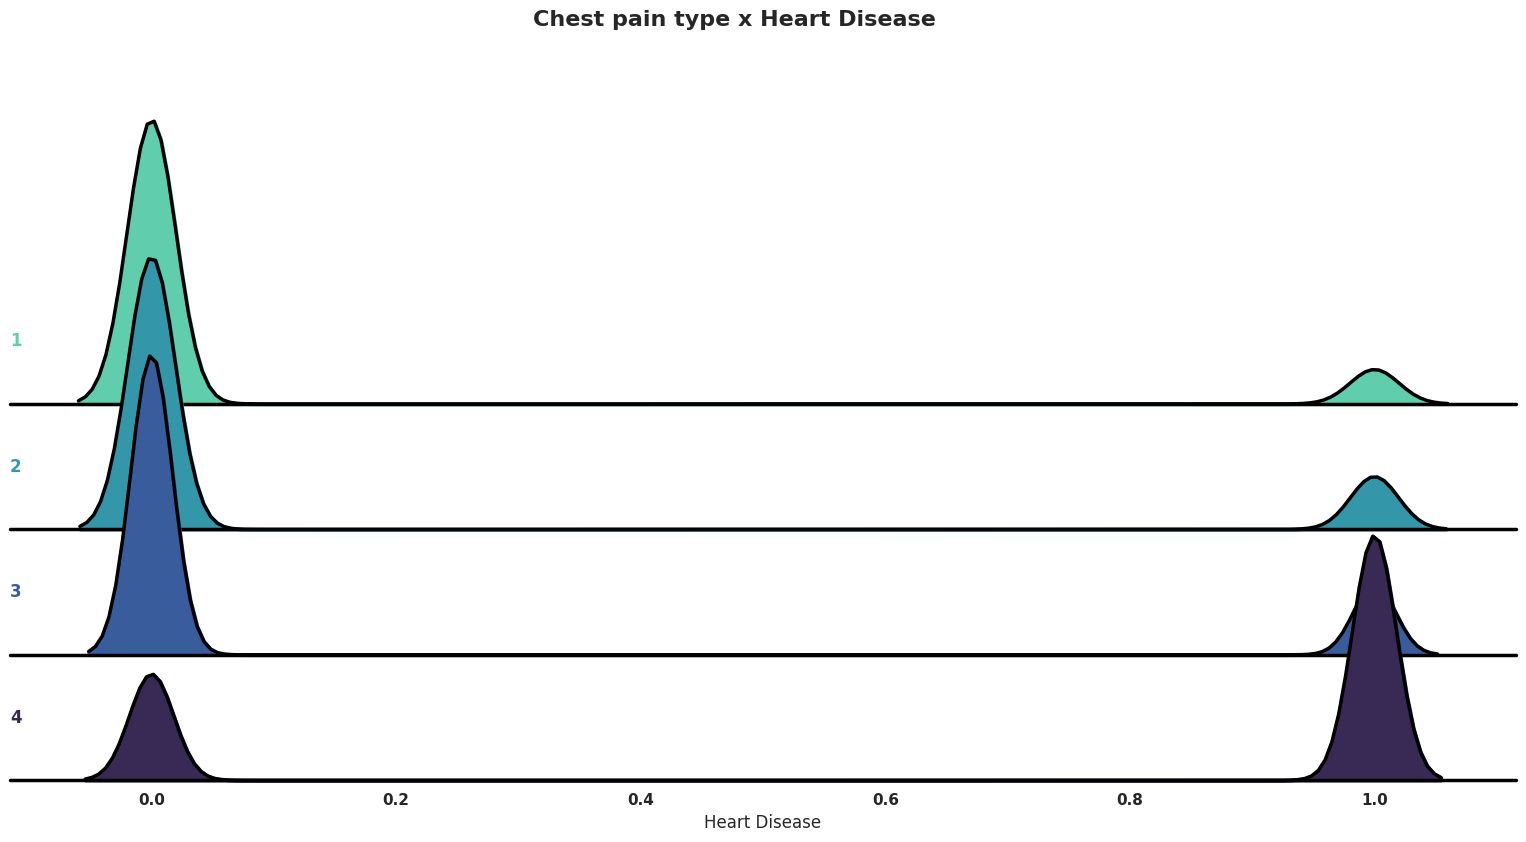

In [8]:
ridgeline(
    train,
    x="Heart Disease",
    row="Chest pain type",
    title=f"Chest pain type x Heart Disease",
    xlabel="Heart Disease",
    pallete="mako_r"
)

sns.set(rc=rc)

In [9]:
def plot_box(df, target, cols=3, colors=['#0B90A7','#E63946', '#E9C46A'], figsize=(15, 8), y_title=None, title=None, props=props):
    columns = df.select_dtypes('int').columns
    rows = np.ceil(len(columns) / cols).astype(int)

    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
    
    yt_labels = []
    for i, x in enumerate(columns):
        if x == target:
            continue
            
        current_ax = ax[i // cols, i % cols]
        sns.boxplot(data=df, y=target, ax=current_ax, x=x, orient='h', palette=colors, **props)
        current_ax.set_xlabel(x)
        
        if y_title and i % cols == 0:
            if len(yt_labels) == 0:
                yt_labels = [label.get_text() for label in current_ax.get_yticklabels()]
            current_ax.set_ylabel(y_title)
            current_ax.set_yticklabels(yt_labels)
        else:
            current_ax.set_ylabel('')
            current_ax.set_yticklabels('')
            
    if title:
        fig.suptitle(title, fontsize=18, fontweight='bold')

    if len(columns) - 1 < (rows * cols):
        for i in range(len(columns) - 1, rows * cols):
            fig.delaxes(ax.flatten()[i])

    legend_elements = [
        Patch(facecolor=colors[0], edgecolor='black', label='Absence'),
        Patch(facecolor=colors[1], edgecolor='black', label='Presence')
    ]

    fig.legend(
        handles=legend_elements,
        loc='upper center',
        ncol=2,
        bbox_to_anchor=(0.5, .94),
        frameon=False
    )
    
    fig.tight_layout()
    plt.show()

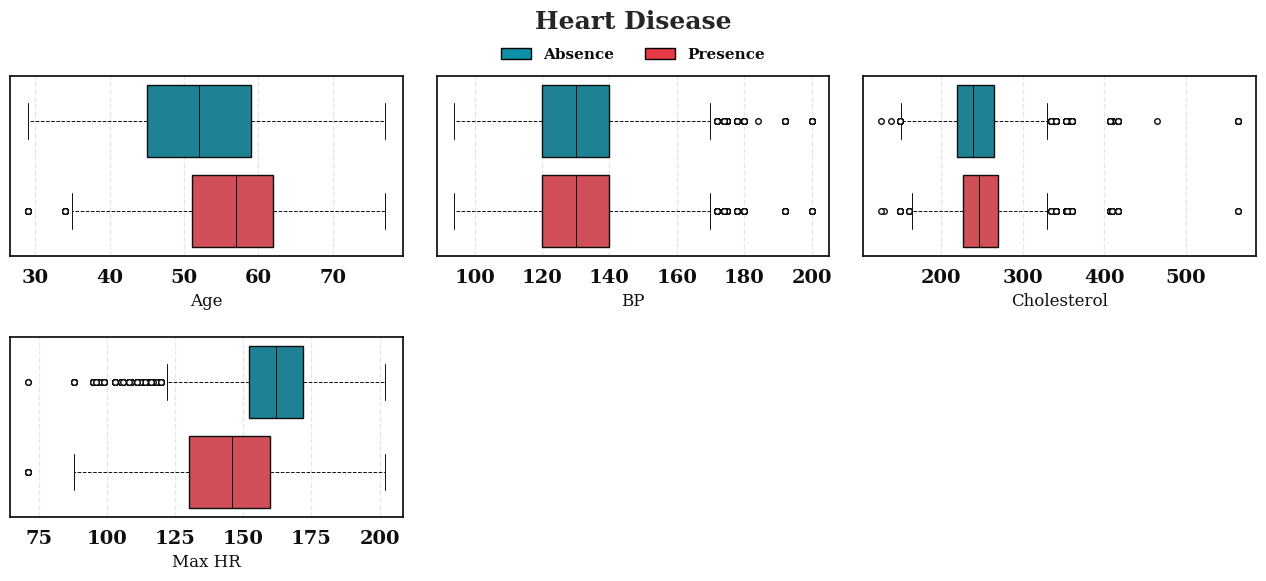

In [10]:
cat = ["id", "FBS over 120", 
       "Sex", "Chest pain type", 
       "EKG results", "Exercise angina", 
       "Slope of ST", "Number of vessels fluro", 
       "Thallium"]

plot_box(
    train.drop(cat, axis=1), 
    'Heart Disease', 
    figsize=(13, 6), 
    title='Heart Disease'
)

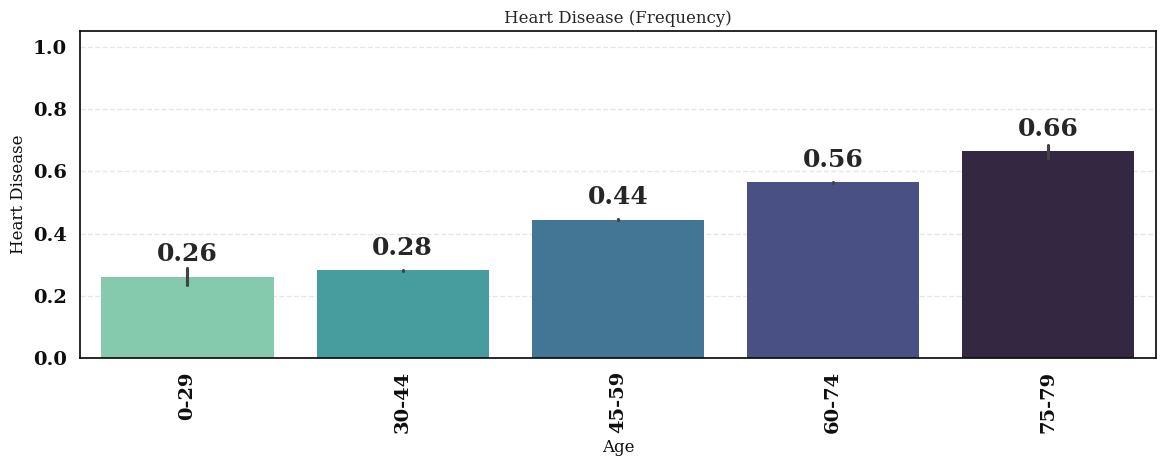

In [11]:
tmp = train.copy()

tmp['Age'] = pd.cut(tmp.Age, 
                    bins=[0, 30, 45, 60, 75, 80], 
                    labels=['0-29','30-44','45-59','60-74','75-79'], 
                    right=False)

plt.figure(figsize=(12,5))

sns.barplot(
    data=tmp,
    x="Age",
    y="Heart Disease",
    palette="mako_r",
    edgecolor="none"
)

for i, v in enumerate(tmp.groupby('Age')['Heart Disease'].mean()):
    plt.text(i, v + 0.05, f"{v:.2f}", ha='center')

plt.xticks(rotation=90)
plt.xlabel("Age")
plt.title("Heart Disease (Frequency)")

plt.ylim(0,1.05)
plt.tight_layout()
plt.show()

In [12]:
def plot_kde(df1:pd.DataFrame, 
             df2:pd.DataFrame, 
             cols:int = 3, 
             fill:bool = True, 
             figsize:tuple = (15, 12),
             colors:list = ["#0B90A7", "#E63946"], 
             title:str = None) -> None:

    df1 = df1.copy()
    df2 = df2.copy()

    df1.drop([settings().identifier, settings().target], axis=1, inplace=True)
    df2.drop([settings().identifier], axis=1, inplace=True)
    
    numeric_columns = df1.select_dtypes(include='number').columns
    rows = np.ceil(len(numeric_columns) / cols).astype(int)

    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)

    for i, x in enumerate(numeric_columns):
        current_ax = ax[i // cols, i % cols]
        sns.kdeplot(x=x,
                    color=colors[0],
                    fill=fill,
                    data=df1,
                    label='Train',
                    ax=current_ax)
        sns.kdeplot(x=x,
                    color=colors[1],
                    fill=fill,
                    data=df2,
                    label='Test',
                    ax=current_ax)
        current_ax.set_xlabel(x)
    
    if title:
        fig.suptitle(title, fontsize=18, fontweight='bold')

    if len(numeric_columns) < (rows * cols):
        for i in range(len(numeric_columns), rows * cols):
            fig.delaxes(ax.flatten()[i])

    legend_elements = [
        Patch(facecolor=colors[0], edgecolor='black', label='Train'),
        Patch(facecolor=colors[1], edgecolor='black', label='Test')
    ]

    fig.legend(
        handles=legend_elements,
        loc='upper center',
        ncol=2,
        bbox_to_anchor=(0.5, .96),
        frameon=False
    )

    fig.tight_layout()
    plt.show()

* **Main takeaways:**
    1. **Distributions look similar for both datasets**
    2. **Class 1 is almost nonexistent on EKG results**
    3. **Classes 2 and 3 of EKG results have similar proportions ~50/50**
    4. **ST depression with a heavy right tail, mostly because of the zeroes**

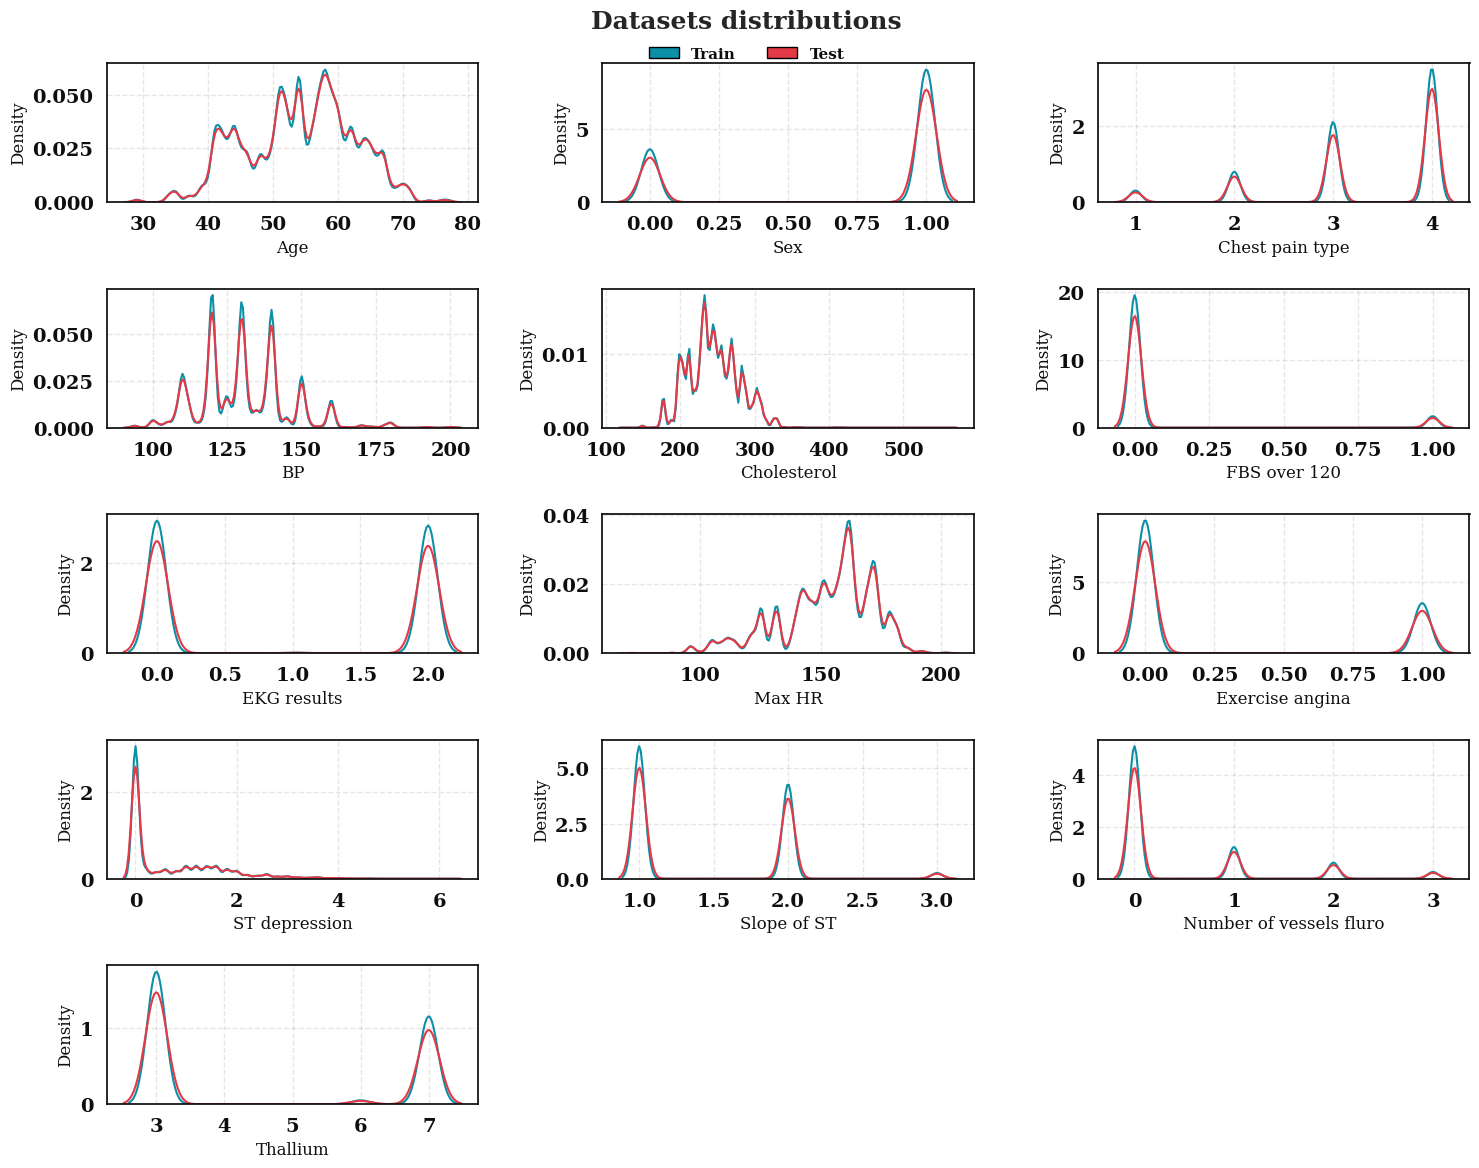

In [13]:
plot_kde(train, test, fill=False, title='Datasets distributions')

<div style="font-family: serif; font-weight: bold; text-align: center;">
  <h1>
    ✨ Model
  </h1>
</div>

In [14]:
X, y = train.drop("Heart Disease", axis=1), train["Heart Disease"].to_numpy(dtype=float)

X_test = test

In [15]:
mic = mutual_info_classif(X, y)

<Axes: ylabel='feature'>

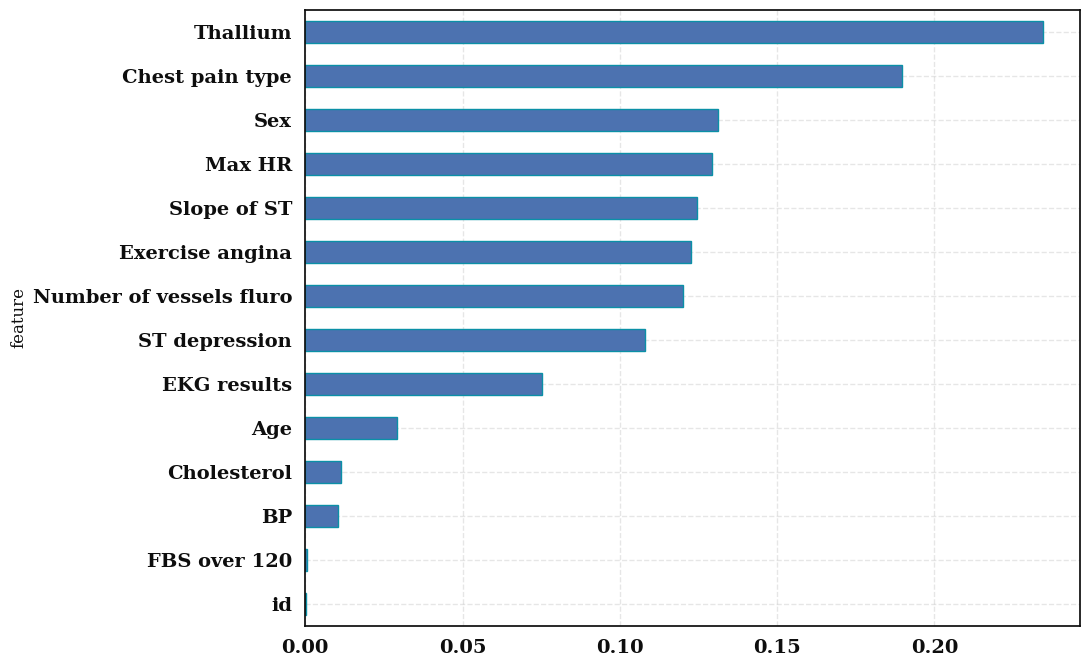

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))

pd.DataFrame(
    {"feature": X.columns, 
     "Mutual Information": mic}
).set_index("feature")["Mutual Information"].sort_values().plot.barh(ax=ax)

In [17]:
for data in [train, test]:
    data.drop([params.identifier], axis=1, inplace=True)

In [18]:
X, y = train.drop("Heart Disease", axis=1), train["Heart Disease"].to_numpy(dtype=float)

In [19]:
skf = StratifiedKFold(n_splits=params.splits, 
                      shuffle=params.shuffle,
                      random_state=867)

roc = []
console = Console()

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf = Pipeline([
        ('Scaler', StandardScaler()),
        ('lgb', lgb.LGBMClassifier(
            verbose=-1)
        )
    ])

    clf.fit(X_train, y_train)

    roc.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

    console.print(f"Fold {i+1:02d} → ROC AUC: {roc[-1]:.4f}", style="bold blue")

print()
mean_roc = np.mean(roc)
std_roc = np.std(roc)
console.print(f"Mean ROC AUC: {mean_roc:.4f} ± {std_roc:.4f}", style="bold magenta")

Fold 01 → ROC AUC: 0.9544

Fold 02 → ROC AUC: 0.9542

Fold 03 → ROC AUC: 0.9541

Fold 04 → ROC AUC: 0.9536

Fold 05 → ROC AUC: 0.9556

Fold 06 → ROC AUC: 0.9563

Fold 07 → ROC AUC: 0.9568

Fold 08 → ROC AUC: 0.9537

Fold 09 → ROC AUC: 0.9553

Fold 10 → ROC AUC: 0.9537

Mean ROC AUC: 0.9548 ± 0.0011

In [20]:
lbm = Pipeline([('Scaler', StandardScaler()),
                ('lgb', lgb.LGBMClassifier(verbose=-1))])

lbm.fit(X, y)

y_preds = lbm.predict_proba(test)[:, 1]
sub["Heart Disease"] = y_preds

sub.to_csv('submission.csv', index=False)

In [21]:
sub.head()

id  Heart Disease
0  630000       0.938504
1  630001       0.009641
2  630002       0.980983
3  630003       0.005645
4  630004       0.196093